# Comparison to SOTA

This notebook contains a comparison of the Vietoris-Rips (VR) persistent homology (PH) computation (on the GPU) implemented in `chofer_torchex` to the implementations available via `dionysus` (v2) and `ripser` (which is SOTA in terms of runtime).

This runtime study is a small-scale version of the runtime study in 

**Connectivity-Optimized Representation Learning via Persistent Homology**    
C. Hofer, R. Kwitt, M. Dixit and M. Niethammer    
ICML '19    
[Online](http://proceedings.mlr.press/v97/hofer19a.html)

In [1]:
import sys

In [2]:
# LOCALLY INSTALL RIPSER
!{sys.executable} -m pip install ripser

     |████████████████████████████████| 79 kB 1.1 MB/s eta 0:00:011
  Created wheel for ripser: filename=ripser-0.4.1-cp37-cp37m-linux_x86_64.whl size=426019 sha256=7b1e03f55f19162b8cf150d455dc7e0b072fb9b6d9578d3562cf94a4b39b330d
  Stored in directory: /home/pma/chofer/.cache/pip/wheels/8e/a8/4c/8b2a78c679fbb09f7a22995fc5fe285e9c0336e25e2b3771ff
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18092 sha256=ff95cd7c6db6146df50d31cad0dcff7ec2978ade6bb9b8dc8a45ec1b60f31f66
  Stored in directory: /home/pma/chofer/.cache/pip/wheels/d2/9f/a8/67f1b86e47cd17338d3d07939f4660378e65b758c4594f96e3
Successfully built ripser hopcroftkarp


In [3]:
# LOCALLY INSTALL DIONYSUS
!{sys.executable} -m pip install dionysus

Processing /home/pma/chofer/.cache/pip/wheels/18/42/ed/40d587d62cfde0767cb6d0d3fb9c8f5c9c64e83b647f14365d/dionysus-2.0.6-cp37-cp37m-linux_x86_64.whl


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from collections import defaultdict

# IMPORT RIPSER and DIONYSUS
from ripser import ripser
import dionysus as d

import torch
import time

from scipy.spatial.distance import pdist

from sklearn import datasets

from chofer_torchex.pershom import vr_persistence_l1, vr_persistence

device = 'cuda'

In [5]:
def gen_random_10D_data(n):
    return np.random.randn(n,10)  

def gen_circlces(n):
    return datasets.make_circles(
        n_samples=n, 
        noise=0.05, 
        factor=0.5)[0]

N = np.arange(50,500,50)

times = defaultdict(list)

f = gen_random_10D_data

for n in N:
    trials = defaultdict(list)
    print('Evaluating N={}'.format(n))
    
    for i in np.arange(50):
        
        #Generate data
        x = f(n)
        D_l1 = pdist(x, metric='cityblock')
        thr_l1 = np.max(D_l1.ravel())

        X = torch.Tensor(x).to(device)
        
        # Timing chofer_torchex
        t0 = time.time()
        l, _ = vr_persistence_l1(X.contiguous(),0, 0);
        t1 = time.time()
        trials['chofer_torchex'].append(t1-t0)
        
        if 'ripser' in sys.modules:        
            t0 = time.time()
            ripser(x, maxdim=0, thresh=thr_l1, metric='manhattan')
            t1 = time.time()
            trials['ripser'].append(t1-t0)
        
        if 'dionysus' in sys.modules: 
            t0 = time.time()
            dd = pdist(x, metric='cityblock')
            filt = d.fill_rips(dd, 1, thr_l1)
            m = d.cohomology_persistence(filt)
            t1 = time.time()
            trials['dionysus'].append(t1-t0)
        
    times[n] = trials

Evaluating N=50
Evaluating N=100
Evaluating N=150
Evaluating N=200
Evaluating N=250
Evaluating N=300
Evaluating N=350
Evaluating N=400
Evaluating N=450


In [6]:
methods = []
if 'ripser' in sys.modules:
    methods.append('ripser')
if 'dionysus' in sys.modules:
    methods.append('dionysus')
methods.append('chofer_torchex')

T = np.zeros((len(N),3))
S = np.zeros((len(N),3))
for j,(k,v) in enumerate(times.items()):
    for i, method in enumerate(methods):
        T[j,i] = np.array(v[method]).mean()
        S[j,i] = np.array(v[method]).std()

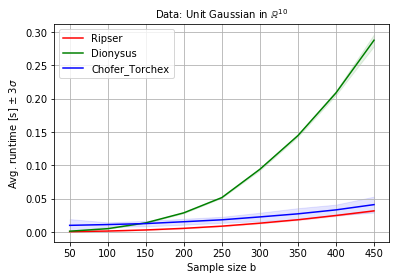

In [7]:
colors = ['red', 'green', 'blue']

plt.figure(figsize=(6,4))
for i, method in enumerate(methods):
    plt.plot(N, T[:,i], label=method.title(), color=colors[i])
    plt.fill_between(N, T[:,i]-3*S[:,i], T[:,i]+3*S[:,i], color=colors[i], alpha=0.1)
    
plt.legend()
plt.grid()
plt.xlabel('Sample size b')
plt.ylabel(r'Avg. runtime [s] $\pm$ 3$\sigma$')
plt.title(r'Data: Unit Gaussian in $\mathbb{R}^{10}$', fontsize=10)
plt.savefig('/tmp/normal10d_runtime.pdf', bbox_inches='tight')

Run a simple sanity check that all VR PH computations return the same result.

In [8]:
# Sample data
x = f(200)

# Compute l1 distance matrix and get max. pairwise distance = threshold
D_l1 = pdist(x, metric='cityblock')
thr_l1 = np.max(D_l1.ravel())

# Run Ripser
dgm_ripser = ripser(x, maxdim=0, thresh=thr_l1, metric='manhattan')['dgms']

# Run Ours
X = torch.Tensor(x).to(device)
l, _ = vr_persistence_l1(X.contiguous(),0, 0);

# Run Dionysus
filt = d.fill_rips(D_l1, 1, thr_l1)
m = d.cohomology_persistence(filt)
dgms = d.init_diagrams(m, filt)

In [9]:
assert(np.abs(dgm_ripser[0][:,1][:-1] - l[0].cpu().numpy()[:,1]).sum() < 1e-4)
assert(np.abs(sorted([x.death for x in dgms[0]])[:-1] - l[0].cpu().numpy()[:,1]).sum() < 1e-4)
assert(np.abs(dgm_ripser[0][:,1][:-1] - sorted([x.death for x in dgms[0]])[:-1]).sum() < 1e-4)